BERT, Classfication layer

BERT, Classfication layer

In [1]:
name = "bert_pooling"

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


train_data = pd.read_csv('../datasets/data_train.csv')
test_data = pd.read_csv('../datasets/data_test.csv')
valid_data = pd.read_csv('../datasets/data_valid.csv')

all_labels = pd.concat([train_data["label"], test_data["label"], valid_data["label"]])
label_encoder = LabelEncoder()
label_encoder.fit(all_labels)

LabelEncoder()

In [3]:
def extract_texts_labels(data, label_encoder):
    texts = data['data'].values
    labels = data['label'].values
    encoded_labels = label_encoder.transform(labels)
    return texts, encoded_labels

In [4]:
train_texts, train_labels = extract_texts_labels(train_data, label_encoder)
test_texts, test_labels = extract_texts_labels(test_data, label_encoder)
valid_texts, valid_labels = extract_texts_labels(valid_data, label_encoder)


In [5]:
from transformers import BertTokenizer

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('google-bert/bert-base-german-cased')

# Tokenize the data
train_encodings = tokenizer(train_texts.astype(str).tolist(), truncation=True, padding='max_length', max_length=400)
test_encodings = tokenizer(test_texts.astype(str).tolist(), truncation=True, padding='max_length', max_length=400)
valid_encodings = tokenizer(valid_texts.astype(str).tolist(), truncation=True, padding='max_length', max_length=400)

In [6]:
import tensorflow as tf

def create_dataset(encodings, labels):
    dataset = tf.data.Dataset.from_tensor_slices((
        dict(encodings),
        labels
    ))
    return dataset

train_dataset = create_dataset(train_encodings, train_labels)
test_dataset = create_dataset(test_encodings, test_labels)
valid_dataset = create_dataset(valid_encodings, valid_labels)

2024-08-04 21:37:12.797760: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2024-08-04 21:37:12.797785: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2024-08-04 21:37:12.797791: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2024-08-04 21:37:12.797804: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-08-04 21:37:12.797813: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [9]:
from transformers import TFBertModel

# Load the BERT model for sequence classification with the number of output labels
bert_model = TFBertModel.from_pretrained('google-bert/bert-base-german-cased', num_labels=len(label_encoder.classes_), output_hidden_states = True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [10]:
input_ids = tf.keras.Input(shape=(400,), dtype=tf.int32, name='input_ids')
attention_mask = tf.keras.Input(shape=(400,), dtype=tf.int32, name='attention_mask')

bert_output = bert_model([input_ids, attention_mask])
sequence_output = bert_output.last_hidden_state

# Pooling layer
pooled_output = tf.keras.layers.GlobalAveragePooling1D()(sequence_output)

# Add a dropout layer
pooled_output = tf.keras.layers.Dropout(0.3)(pooled_output)

# Add a classification layer
output = tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax')(pooled_output)

model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

In [12]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=3e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[ "accuracy" ]
)


In [13]:
# Train the model with early stopping callback
model.fit(train_dataset.shuffle(1000).batch(64),
          validation_data=valid_dataset.batch(64),
          epochs=3)


Epoch 1/3


/opt/homebrew/Caskroom/miniconda/base/envs/tf2/lib/python3.10/site-packages/tf_keras/src/engine/functional.py:641: UserWarning: Input dict contained keys ['token_type_ids'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
/opt/homebrew/Caskroom/miniconda/base/envs/tf2/lib/python3.10/site-packages/tf_keras/src/backend.py:5729: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


2024-08-04 21:38:06.715994: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


368/368 [==============================] - 2171s 6s/step - loss: 1.1753 - accuracy: 0.4767 - val_loss: 1.1038 - val_accuracy: 0.5181
Epoch 2/3
368/368 [==============================] - 2342s 6s/step - loss: 1.0663 - accuracy: 0.5389 - val_loss: 1.0633 - val_accuracy: 0.5379
Epoch 3/3
368/368 [==============================] - 2471s 7s/step - loss: 0.9720 - accuracy: 0.5882 - val_loss: 1.0895 - val_accuracy: 0.5398


In [14]:
# Evaluate the model
loss, accuracy = model.evaluate(test_dataset.batch(32))
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

246/246 [==============================] - 184s 746ms/step - loss: 1.0849 - accuracy: 0.5469
Loss: 1.084949254989624
Accuracy: 0.5469267964363098


In [17]:
model.save(name + ".h5")
tokenizer.save_pretrained(name + "_tokenizer")

/opt/homebrew/Caskroom/miniconda/base/envs/tf2/lib/python3.10/site-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


('bert_pooling_tokenizer/tokenizer_config.json',
 'bert_pooling_tokenizer/special_tokens_map.json',
 'bert_pooling_tokenizer/vocab.txt',
 'bert_pooling_tokenizer/added_tokens.json')

In [19]:
import numpy as np
predictions = model.predict(test_dataset.batch(32))
predicted_labels = np.argmax(predictions, axis=1)

# Decode class labels to original labels
decoded_predictions = label_encoder.inverse_transform(predicted_labels)

# True labels from the test set
true_labels = label_encoder.inverse_transform(test_labels)

# Create a DataFrame to compare
comparison_df = pd.DataFrame({'Text': test_texts, 'True Label': true_labels, 'Predicted Label': decoded_predictions})

246/246 [==============================] - 132s 536ms/step


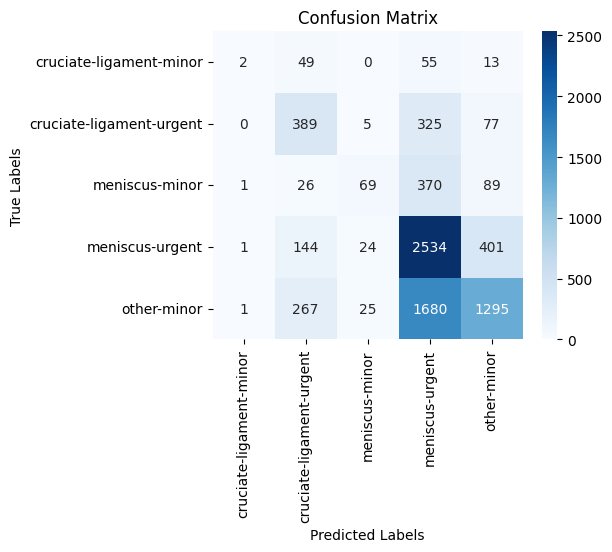

In [20]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(true_labels, decoded_predictions, labels=label_encoder.classes_)

# Plot the confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [21]:
from sklearn.metrics import classification_report
print(classification_report(true_labels, decoded_predictions, target_names=label_encoder.classes_))

                          precision    recall  f1-score   support

 cruciate-ligament-minor       0.40      0.02      0.03       119
cruciate-ligament-urgent       0.44      0.49      0.47       796
          meniscus-minor       0.56      0.12      0.20       555
         meniscus-urgent       0.51      0.82      0.63      3104
             other-minor       0.69      0.40      0.50      3268

                accuracy                           0.55      7842
               macro avg       0.52      0.37      0.37      7842
            weighted avg       0.58      0.55      0.52      7842



In [22]:
from sklearn.metrics import classification_report
report = classification_report(true_labels, decoded_predictions, target_names=label_encoder.classes_, output_dict=True)

In [23]:
df = pd.DataFrame(report).transpose()
df.to_csv(name + "_report.csv")